### Fine-tune the pre-trained FaceNet model towards the QRI Face Dataset (85 images, 85 peaple) using binary loss function

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras import backend as K
K.set_image_data_format('channels_first')

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Lambda
from keras.layers import Input
from keras import optimizers

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

import cv2

In [ ]:
from utils.FaceNet_utils import one_hot, distance_based_prediction, evaluate_model, face_dist, load_QRIFaceData, load_base_model

In [3]:
FNModel = load_base_model()

In [4]:
FNModel.count_params()

3743280

In [5]:
FaceData, labels, labels_OH, name_list = load_QRIFaceData()
print(FaceData.shape)
print(labels.shape)
print(labels_OH.shape)
print(name_list)

(85, 3, 96, 96)
(85,)
(85, 85)
['Hamad.Darabi', 'Ralph.Merry', 'Aaron.Close', 'Abdoulaye.Wedraogo', 'Adel.Heiba', 'Afshan.Jafferi', 'Agustin.Maqui', 'Aldo.Sanchez', 'Alexander.Aronovitz', 'Ali.Garkasi', 'Ali.Karima', 'Alisher.Yunuskhojayev', 'Amir.Kianinejad', 'Amir.Rahmani', 'Amir.Salehi', 'Ana.Negreira', 'Anastasiya.Protasov', 'Andrew.Dingee', 'Bart.Piela', 'Bijay.Banthia', 'Bill.Daugherty', 'Brian.Ames', 'Cedric.Fraces', 'Chad.Liu', 'Christophe.Nogaret', 'David.Castineira', 'David.Hoyt', 'David.Tyree', 'Denis.Prokofiev', 'Dilay.Watson', 'Don.Gehring', 'Ehsan.Davani', 'Ernesto.Cisnernos', 'Fayadhoi.Ibrahima', 'Franklin.Useche', 'Henry.Kernan', 'Hooman.Laali', 'Humberto.Godinez', 'Izzet.Arslan', 'Jacqueline.Bosworth', 'Jaime.Avendano', 'James.Howard', 'Jeff.Hutchison', 'Jenna.Salamah', 'Jeremy.Ma', 'Jeremy.Xia', 'Jesse.Shumway', 'Johanna.Smith', 'John.Marshall', 'John.Watkins', 'Juan.Troncoso', 'Kara.Bennett', 'Karen.Chen', 'Kate.Lewis', 'Kun.Liu', 'Lewis.Pham', 'Luis.Piasco', 'Maria.

In [6]:
nPeople = labels_OH.shape[1]
nFace = FaceData.shape[0]
print('Number of people: %d, Number of faces: %d' % (nPeople, nFace))

Number of people: 85, Number of faces: 85


In [7]:
%time FaceEmbedding = FNModel.predict(FaceData)

CPU times: user 25.4 s, sys: 427 ms, total: 25.8 s
Wall time: 7.2 s


In [8]:
pca = decomposition.PCA(n_components = 2)

In [9]:
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)

Text(0.5,1,'feature space')

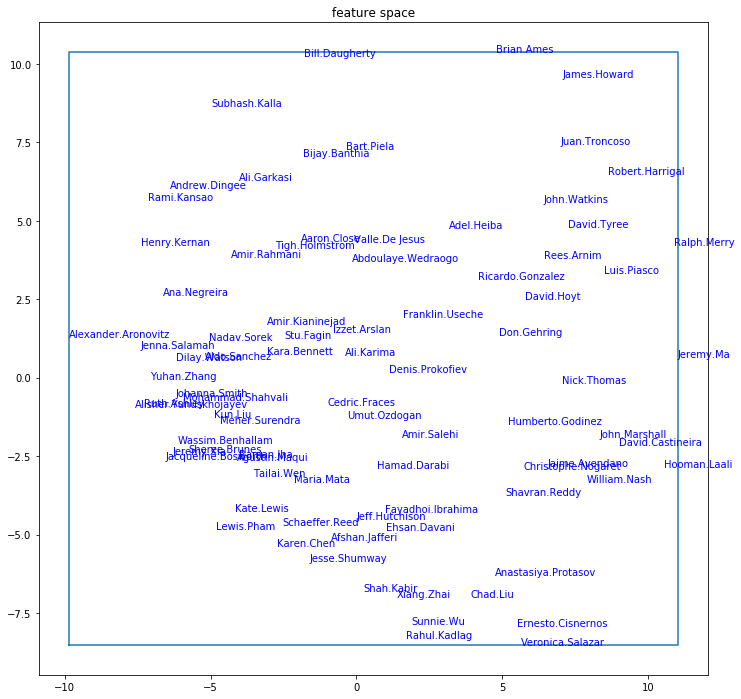

In [10]:
#plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels)
plt.figure(figsize=(12,12))
xmin,xmax = x_feature_pca[:,0].min(),x_feature_pca[:,0].max()
ymin,ymax = x_feature_pca[:,1].min(),x_feature_pca[:,1].max()

plt.plot([xmin,xmax,xmax,xmin,xmin],[ymin,ymin,ymax,ymax,ymin])
for i in range(nPeople):
    plt.text(x_feature_pca[i,0],x_feature_pca[i,1],name_list[i],color='b')
plt.title('feature space')

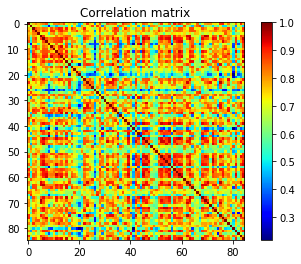

In [11]:
FaceEmbedding_Corr = np.corrcoef(FaceEmbedding)
plt.imshow(FaceEmbedding_Corr,cmap='jet')
plt.title('Correlation matrix')
plt.colorbar()

In [12]:
Distances_cross_dist = []
Distances_cross_dist_pair = []
FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]!=labels[j]:
            Distances_cross_dist.append(FaceEmbedding_Dist[i,j])
            Distances_cross_dist_pair.append((i,j))
            
Distances_cross_dist = np.array(Distances_cross_dist)

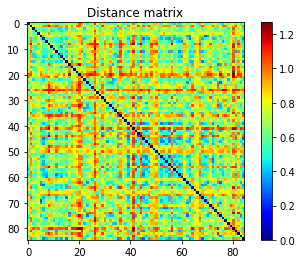

In [13]:
plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

Cross-class distance = 0.736 +\- 0.185


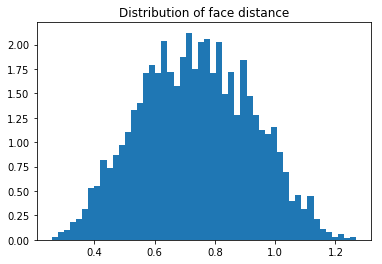

In [14]:
plt.figure()
_ = plt.hist(Distances_cross_dist,bins = 50,normed = True)
plt.title('Distribution of face distance')

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_cross_dist.mean(), Distances_cross_dist.std()))

## Check similar faces

Afshan.Jafferi Schaeffer.Reed 0.2585456426317531


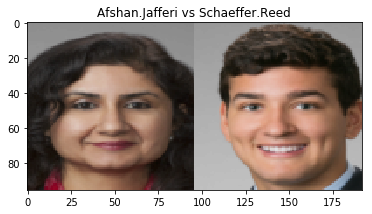

Ruth.Ashley Yuhan.Zhang 0.2738773628807159


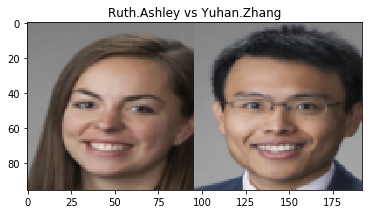

Jeremy.Xia Yuhan.Zhang 0.28034154956903745


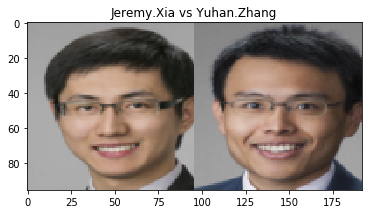

Karen.Chen Lewis.Pham 0.2843592215679023


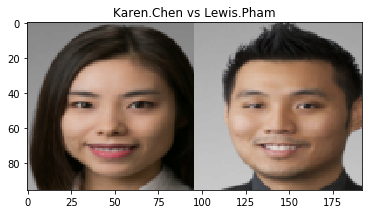

Rahul.Kadlag Sunnie.Wu 0.28727396124866017


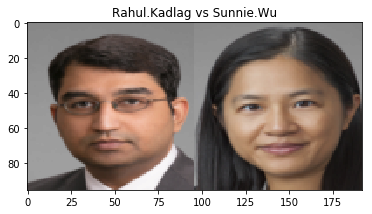

Jeff.Hutchison Maria.Mata 0.2882611344127824


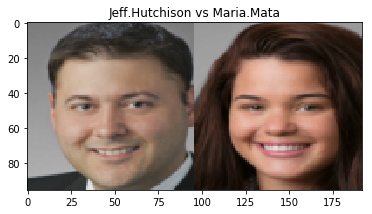

Agustin.Maqui Raman.Jha 0.29010236033328207


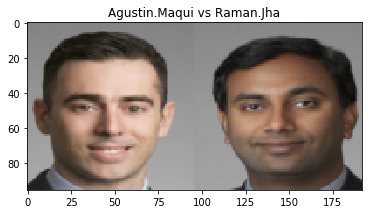

Chad.Liu Sunnie.Wu 0.29638049745871087


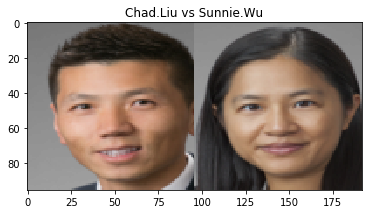

Agustin.Maqui Jeremy.Xia 0.3023093293968681


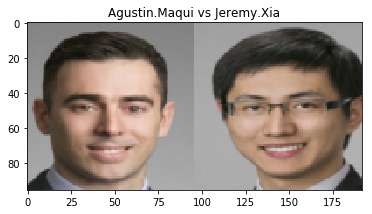

Jacqueline.Bosworth Lewis.Pham 0.303076175648424


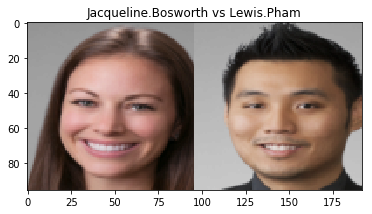

Ana.Negreira Yuhan.Zhang 0.30983575539193625


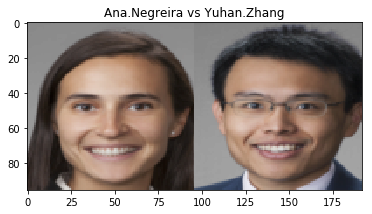

Kate.Lewis Sheree.Brunes 0.3099063686780561


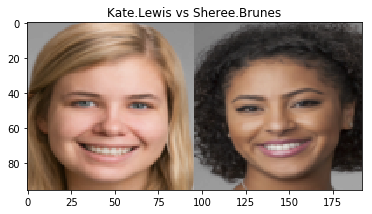

Kun.Liu Sheree.Brunes 0.3124955661749099


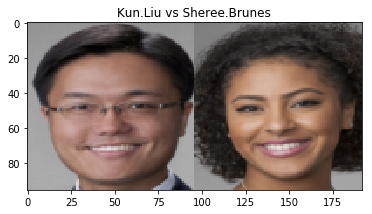

Ana.Negreira Ruth.Ashley 0.3145923035101154


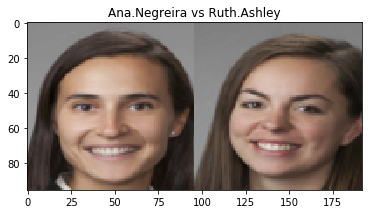

Jacqueline.Bosworth Karen.Chen 0.31621573048476115


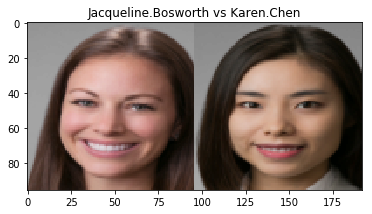

Henry.Kernan Yuhan.Zhang 0.31980575039944265


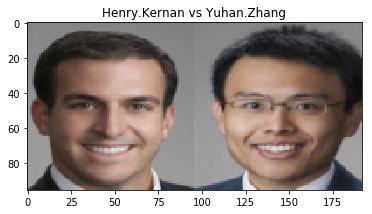

Agustin.Maqui Yuhan.Zhang 0.3215583386516493


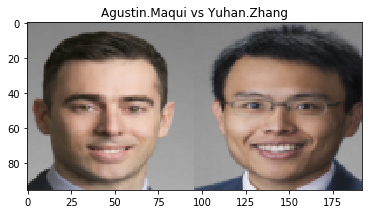

Alisher.Yunuskhojayev Mohammad.Shahvali 0.3236588996501055


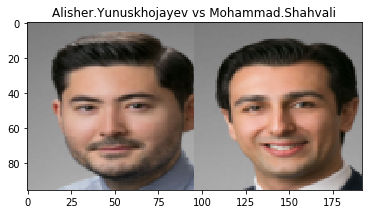

Jesse.Shumway Lewis.Pham 0.32402663995918074


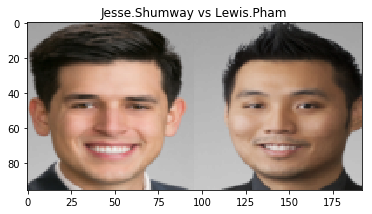

Jacqueline.Bosworth Jeremy.Xia 0.3242040520964849


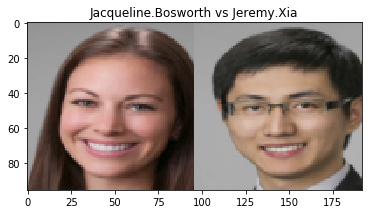

Jeremy.Xia Mohammad.Shahvali 0.3248590205263187


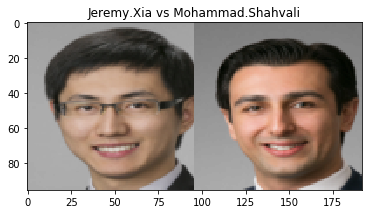

Jesse.Shumway Karen.Chen 0.3271617628977319


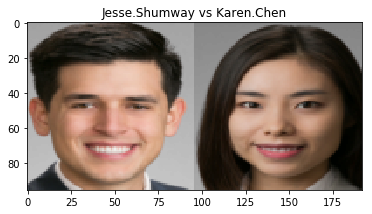

Jeremy.Xia Lewis.Pham 0.32832926529800555


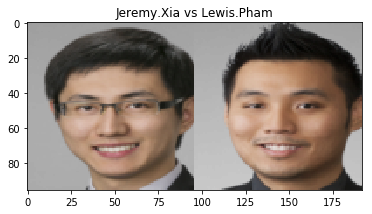

Rahul.Kadlag Shah.Kabir 0.3302811975318918


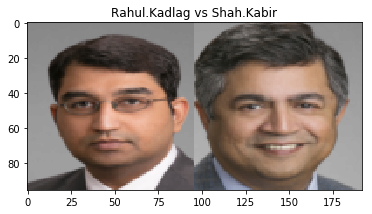

Lewis.Pham Raman.Jha 0.3351688845642077


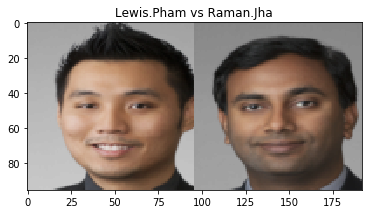

Sunnie.Wu Xiang.Zhai 0.33595515287161415


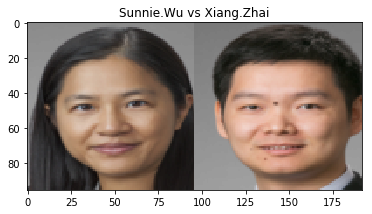

Jacqueline.Bosworth Sheree.Brunes 0.33762893337186495


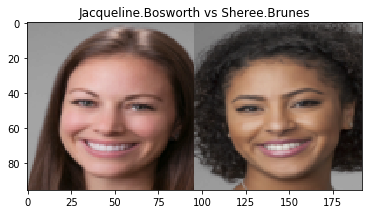

Jeremy.Xia Wassim.Benhallam 0.3388390566630525


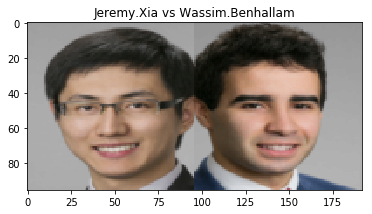

Jesse.Shumway Kate.Lewis 0.3413929899425868


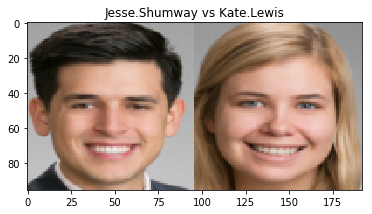

Aldo.Sanchez Nadav.Sorek 0.34324460175089566


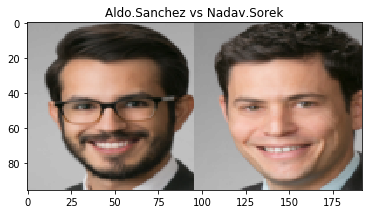

Raman.Jha Ruth.Ashley 0.34402548814069533


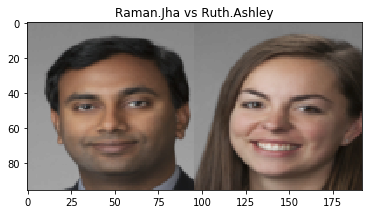

Jacqueline.Bosworth Yuhan.Zhang 0.34411778932127224


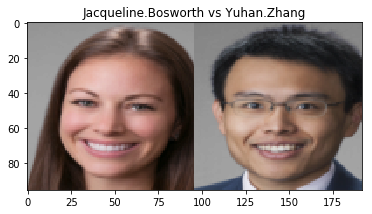

Ana.Negreira Henry.Kernan 0.3474144832262374


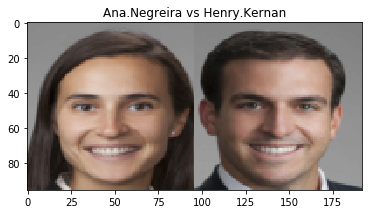

Ali.Garkasi Amir.Rahmani 0.348359435998058


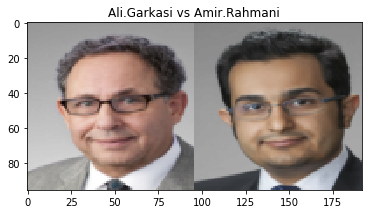

Chad.Liu Rahul.Kadlag 0.34886024468483756


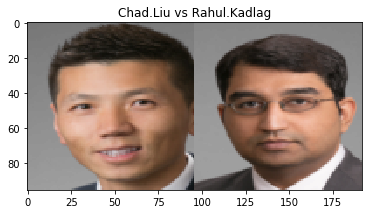

Henry.Kernan Rami.Kansao 0.35041141051876074


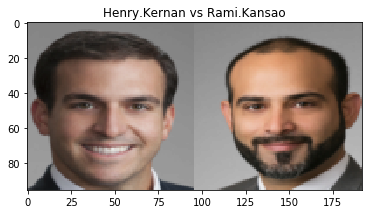

Afshan.Jafferi Shah.Kabir 0.35064892221745925


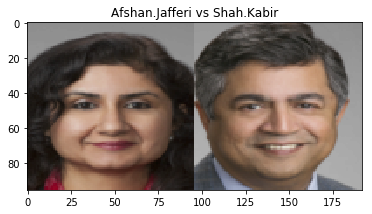

Afshan.Jafferi Raman.Jha 0.3510577976052977


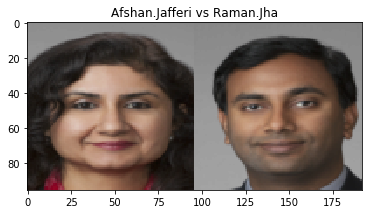

Shah.Kabir Sunnie.Wu 0.35148928876229535


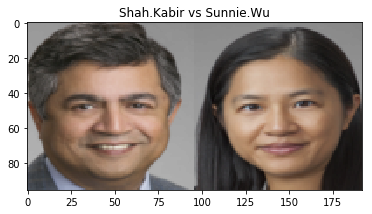

Lewis.Pham Maria.Mata 0.35239025725425915


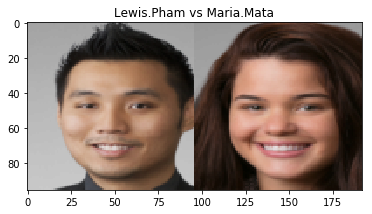

Nadav.Sorek Yuhan.Zhang 0.3574076451473061


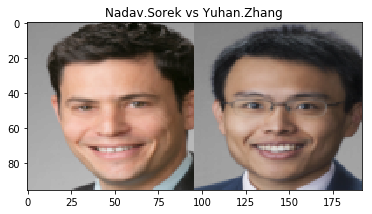

Jeremy.Xia Karen.Chen 0.3587956411332969


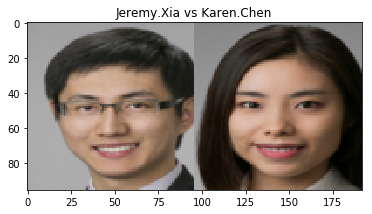

Ehsan.Davani Jesse.Shumway 0.3591166955919256


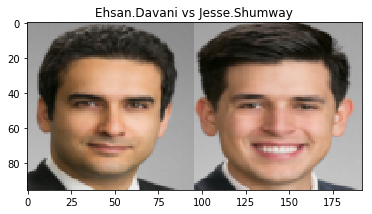

Agustin.Maqui Johanna.Smith 0.3605797399111453


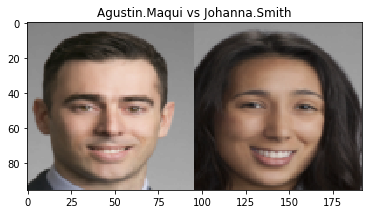

Afshan.Jafferi Rahul.Kadlag 0.36161442623573226


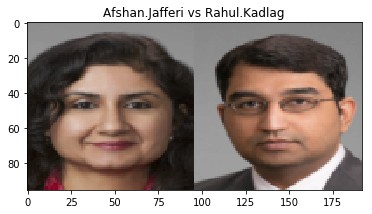

Raman.Jha Yuhan.Zhang 0.36257898933564503


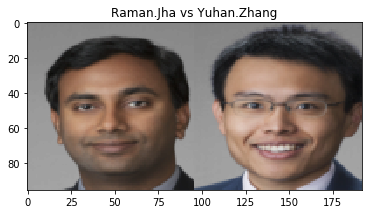

Alisher.Yunuskhojayev Jeremy.Xia 0.36325649919869757


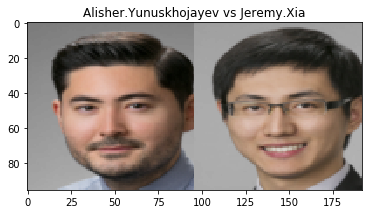

Johanna.Smith Sheree.Brunes 0.3638318407873773


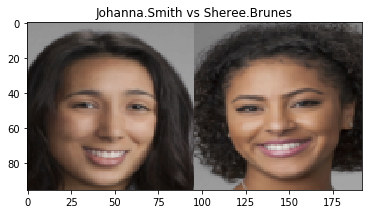

Cedric.Fraces Fayadhoi.Ibrahima 0.3639187623506916


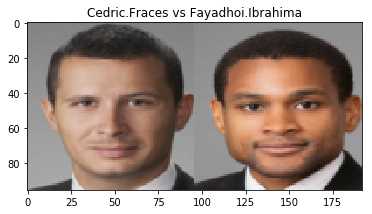

Mohammad.Shahvali Yuhan.Zhang 0.3644419956606496


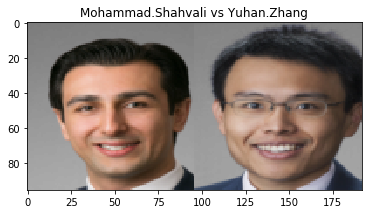

In [15]:
idx = np.argsort(Distances_cross_dist)[:50]
for i in idx:
    (p1,p2) = Distances_cross_dist_pair[i]
    print(name_list[p1], name_list[p2], Distances_cross_dist[i])
    tmp = np.concatenate((FaceData[p1],FaceData[p2]),axis=2)
    plt.figure()
    plt.imshow(np.transpose(tmp, (1,2,0)))
    plt.title(name_list[p1]+' vs '+name_list[p2])
    plt.show()
祈祷。



很多人觉得不可思议，但是换位思考下，如果是一位病人的朋友真诚为老公祈福，希望他的病请快点好等等愿望，你作为亲朋友好友能够去指责她在搞封建迷信，只是顺手点个助力，帮忙转发，你能够拒绝吗？



通过这样的方式，就够完成了裂变，同时也让更多的人就参与进来了。（需要注意的是，不论你是使用小程序哪一种一功能都是需要通过输入手机号码等等基本信息，这其实就是手机用户信息，这些又是一

## Now try to do recognition!

In [16]:
def distance_based_prediction(FaceIm, FaceEmbedding, name_list, th=0.2):
    FaceIm = misc.imresize(FaceIm,(96,96,3))
    FaceIm = np.around(np.transpose(FaceIm, (2,0,1))/255.0, decimals=12)
    FaceVector = FNModel.predict(np.array([FaceIm]))
    D = face_dist(FaceEmbedding,FaceVector)
    i = np.argmin(D)
    if D[i]>th:
        return name_list[i], D[i]
    else:
        return "Not recognizable", D[i]

In [17]:
def get_fullhead(x,y,w,h):
    new_h = int(h*1.6)
    new_w = int(w*1.2)
    y = int(y - h*0.4)
    x = int(x - w*0.1)
    return x,y,new_w,new_h

In [18]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

In [19]:
imName = 'Emmy Army.jpg'
im = misc.imread(imName)

imgray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(im, 1.3, 5)
print(len(faces))

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


23


/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


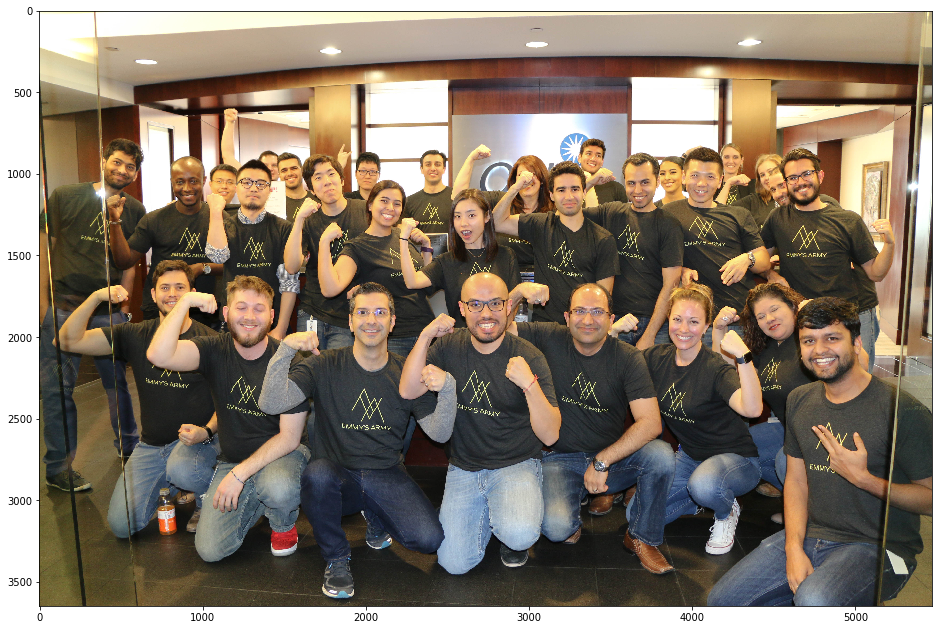

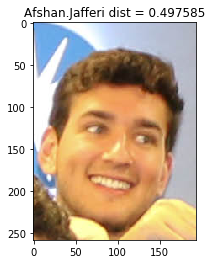

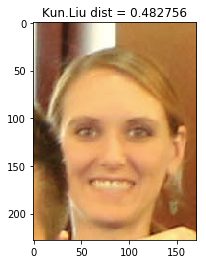

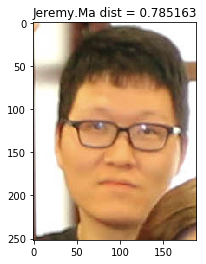

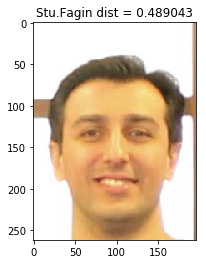

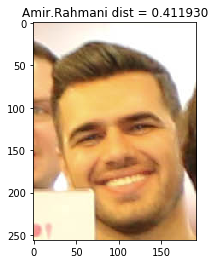

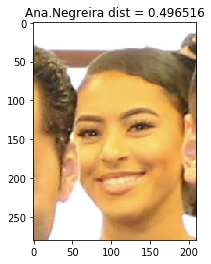

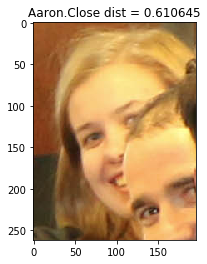

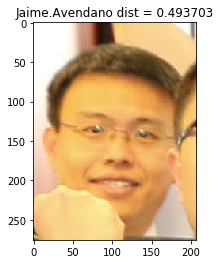

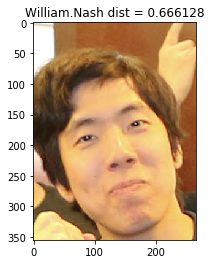

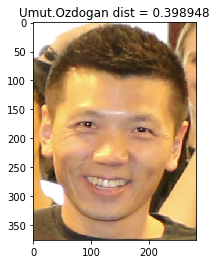

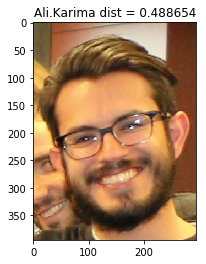

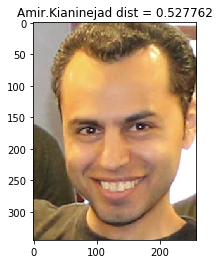

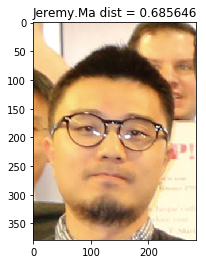

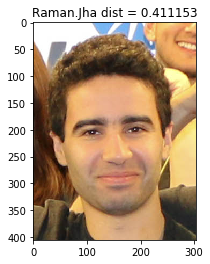

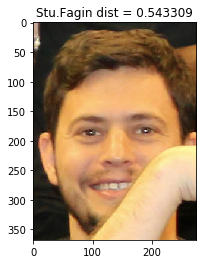

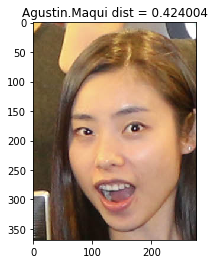

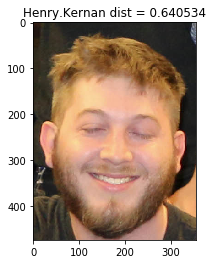

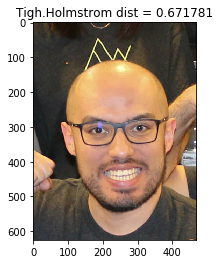

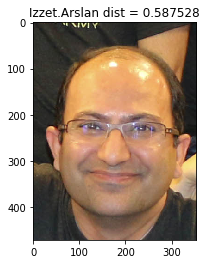

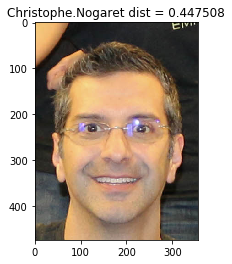

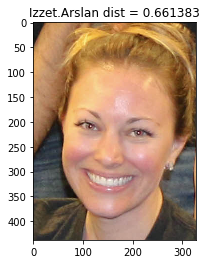

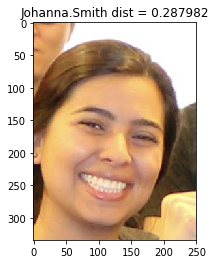

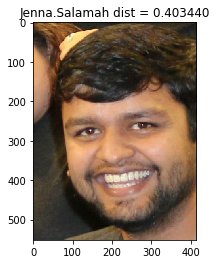

In [20]:
plt.figure(figsize=(16, 12))
plt.imshow(im)
for (x,y,w,h) in faces:
    (x,y,w,h) = get_fullhead(x,y,w,h)
    p, d =  distance_based_prediction(im[y:y+h,x:x+w], FaceEmbedding, name_list)
    #print(p)
    #plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y])
    #plt.text(x,y,p,color='white')
    plt.figure()
    plt.imshow(im[y:y+h,x:x+w])
    plt.title(p + ' dist = %f' % d)
    plt.show()

### Note:
Apparently, the model does not do a good recognition job. Now we need to tune the model for QRI face dataset

## Generate positive and negative combinations to train binary Siamese model built on top of the FaceNet model

In [30]:
def VecDist(tensors):
    dist = K.sum(K.square(tensors[0]-tensors[1]),axis=-1)
    return dist

In [31]:
def Create_Siamese_binary_model(basemodel):
    basemodel_input_shape = basemodel.layers[0].input.get_shape().as_list()[1:]
    
    p1_Input  = Input(basemodel_input_shape)
    p2_Input  = Input(basemodel_input_shape)
    
    p1_Prediction = basemodel(p1_Input)
    p2_Prediction = basemodel(p2_Input)
    
    dist = Lambda(VecDist, output_shape=(1,))([p1_Prediction,p2_Prediction])
    
    SiameseModel = Model(inputs = [p1_Input, p2_Input], outputs = dist)
    
    return SiameseModel 

In [32]:
def binary_loss(y_true, y_pred, threshold = 1.0):

    loss = K.sum(K.maximum(threshold- y_pred, 0.0))
    #loss = K.sum(-y_pred)

    return loss

In [33]:
SiameseModel = Create_Siamese_binary_model(FNModel)

In [34]:
SiameseModel.output

<tf.Tensor 'lambda_2_1/Sum:0' shape=(?,) dtype=float32>

In [35]:
opt = optimizers.adam(lr=0.005, beta_1=0.85, beta_2=0.99, decay=1e-6)
SiameseModel.compile(optimizer = opt, loss = binary_loss)

2000 number of P, N combinations had been identified


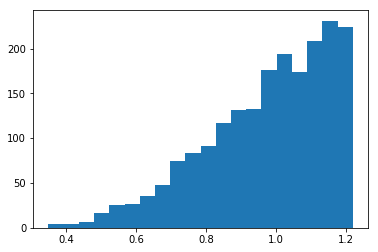

Epoch 1/1
2000/2000 [==============================] - 591s 295ms/step - loss: 1.4138
CPU times: user 25.7 s, sys: 362 ms, total: 26.1 s
Wall time: 6.62 s


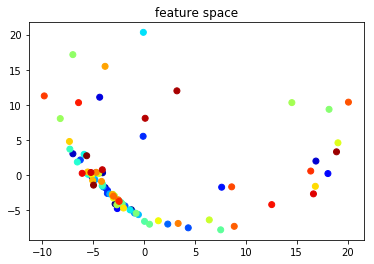

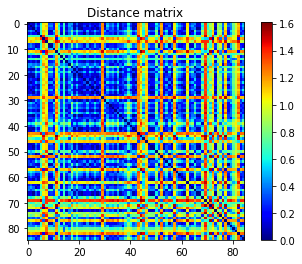

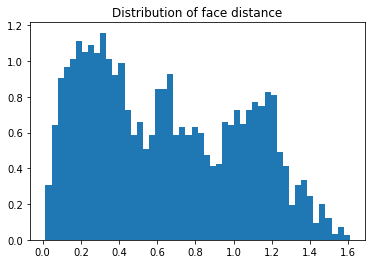

Cross-class distance = 0.644 +\- 0.399
2000 number of P, N combinations had been identified


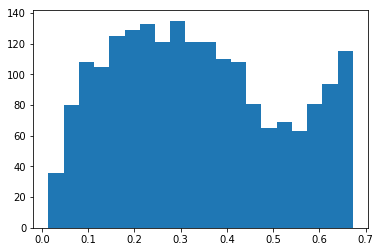

Epoch 1/1
2000/2000 [==============================] - 586s 293ms/step - loss: 1.2404
CPU times: user 25.9 s, sys: 368 ms, total: 26.2 s
Wall time: 6.77 s


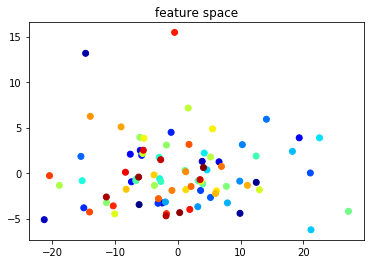

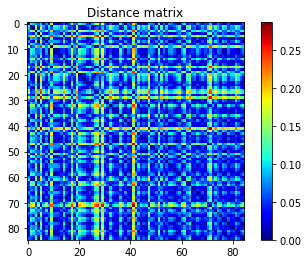

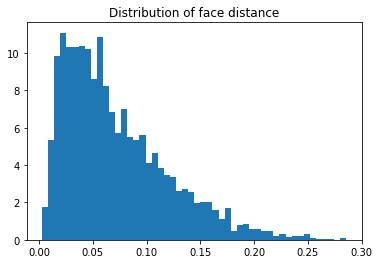

Cross-class distance = 0.072 +\- 0.048
2000 number of P, N combinations had been identified


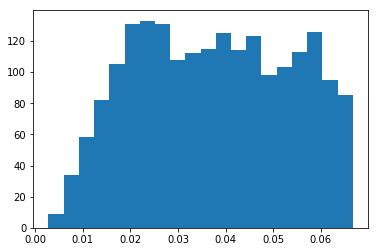

Epoch 1/1
2000/2000 [==============================] - 587s 293ms/step - loss: 1.3419
CPU times: user 25.9 s, sys: 417 ms, total: 26.3 s
Wall time: 7.34 s


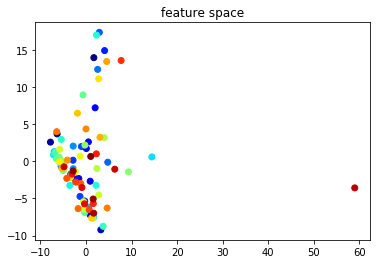

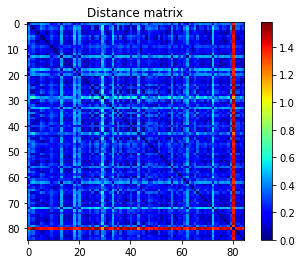

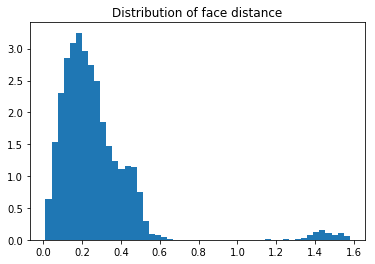

Cross-class distance = 0.267 +\- 0.222
2000 number of P, N combinations had been identified


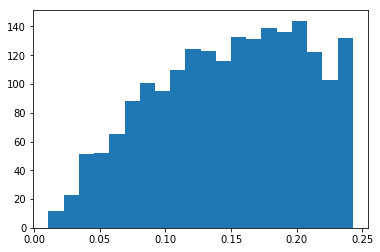

Epoch 1/1
 640/2000 [========>.....................] - ETA: 6:39 - loss: 1.5184

KeyboardInterrupt: 

In [38]:
for i in range(10):
    # find hard to train positive and negative combination
    idx = np.argsort(Distances_cross_dist)
    nPN = 2000
    P = [Distances_cross_dist_pair[i][0] for i in idx[:nPN]]
    N = [Distances_cross_dist_pair[i][1] for i in idx[:nPN]]

    print('%d number of P, N combinations had been identified' % nPN)
    plt.figure()
    plt.hist(Distances_cross_dist[idx[:nPN]],bins=20)
    plt.show()
    #SiameseModel.fit([FaceData[A[:5]],FaceData[P[:5]],FaceData[N[:5]]], np.ones((5,)), epochs = 1, batch_size = 32)
    SiameseModel.fit([FaceData[P],FaceData[N]], np.zeros((nPN,)), epochs = 1, batch_size = 16)
    
    %time FaceEmbedding = FNModel.predict(FaceData)
    
    pca = decomposition.PCA(n_components = 2)
    x_std = StandardScaler().fit_transform(FaceEmbedding)
    x_feature_pca = pca.fit_transform(x_std)
    plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels,cmap='jet')
    plt.title('feature space')
    plt.show()

    Distances_cross_dist = []
    Distances_cross_dist_pair = []
    FaceEmbedding_Dist = np.ones((nFace,nFace))*100
    for i in range(nFace):
        for j in range(i,nFace):
            FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
            FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
            if labels[i]!=labels[j]:
                Distances_cross_dist.append(FaceEmbedding_Dist[i,j])
                Distances_cross_dist_pair.append((i,j))

    Distances_cross_dist = np.array(Distances_cross_dist)

    plt.figure()
    plt.imshow(FaceEmbedding_Dist,cmap='jet')
    plt.title('Distance matrix')
    plt.colorbar()
    plt.show()

    plt.figure()
    _ = plt.hist(Distances_cross_dist,bins = 50,normed = True)
    plt.title('Distribution of face distance')
    plt.show()

    print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_cross_dist.mean(), Distances_cross_dist.std()))
    

In [ ]:
%time FaceEmbedding = FNModel.predict(FaceData)

In [ ]:
pca = decomposition.PCA(n_components = 2)
x_std = StandardScaler().fit_transform(FaceEmbedding)
x_feature_pca = pca.fit_transform(x_std)
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=labels,cmap='jet')
plt.title('feature space')

Distances_cross_dist = []
Distances_cross_dist_pair = []
FaceEmbedding_Dist = np.ones((nFace,nFace))*100
for i in range(nFace):
    for j in range(i,nFace):
        FaceEmbedding_Dist[i,j]=face_dist(FaceEmbedding[i,:],FaceEmbedding[j,:])
        FaceEmbedding_Dist[j,i]=FaceEmbedding_Dist[i,j]
        if labels[i]!=labels[j]:
            Distances_cross_dist.append(FaceEmbedding_Dist[i,j])
            Distances_cross_dist_pair.append((i,j))
            
Distances_cross_dist = np.array(Distances_cross_dist)

plt.figure()
plt.imshow(FaceEmbedding_Dist,cmap='jet')
plt.title('Distance matrix')
plt.colorbar()

plt.figure()
_ = plt.hist(Distances_cross_dist,bins = 50,normed = True)
plt.title('Distribution of face distance')

print('Cross-class distance = %1.3f +\- %1.3f' % (Distances_cross_dist.mean(), Distances_cross_dist.std()))